***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet\Training_and_Analysis\4_CIFAR-100
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "3" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  3
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Import Dataset : CIFAR-100

In [4]:
dataset = datasets.CIFAR100(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR100(version = 'reduce') # importing CIFAR10 Dataset


CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [5]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [6]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [7]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [8]:
coarse_to_medium_array = np.zeros(shape=[number_of_classes_c,number_of_classes_m], dtype=np.int32)
medium_to_fine_array = np.zeros(shape=[number_of_classes_m,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

m_id = np.argmax(dataset['y_train_medium'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_test_medium'])):
    coarse_to_medium_array[c_id[x]][m_id[x]] = 1
    
for x in range(len(dataset['y_test_fine'])):
    medium_to_fine_array[m_id[x]][f_id[x]] = 1

Matrix_coarse_to_medium_OneHot = tf.constant(coarse_to_medium_array, dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(medium_to_fine_array, dtype=tf.float32)

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,tree: Tree,C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=number_of_classes_m)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_medium_class = number_of_classes_m
    no_fine_class = number_of_classes_f

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 16
    SCap_c_dims = 16


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 512], output [batch_size, 2304, 8]
    reshapec = keras.layers.Reshape((256, PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_f_dims, 
                        name="s_caps_medium")(s_caps_f)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                              dataset['tree']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

## log directory

In [12]:
directory = sysenv.log_dir('4_CIFAR_100/HD_CapsNet/W_C_loss')

FOLDER CREATED =  ../../logs/4_CIFAR_100/HD_CapsNet/W_C_loss


In [13]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 1)            0           ['tf.math.reduce_sum_2[0][0]']   
                                                                                                  
 tf.math.argmax (TFOpLambda)    (None,)              0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.argmax_1 (TFOpLambda)  (None,)              0           ['prediction_medium[0][0]']      
                                                                                                  
 tf.math.argmax_5 (TFOpLambda)  (None,)              0           ['input_ym[0][0]']               
          

 da)                                                                                              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.math.maximum_4 (TFOpLambda)  (None, 100)         0           ['tf.math.subtract_10[0][0]']    
                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 100)         0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.m

                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None,)             0           ['tf.math.abs_2[0][0]',          
 )                                                                'tf.math.abs[0][0]']            
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 100)          0           ['tf.math.multiply_16[0][0]',    
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.5036 - prediction_coarse_accuracy: 0.3740 - prediction_medium_accuracy: 0.1828 - prediction_fine_accuracy: 0.0800
  • Coarse Accuracy = 37.40% | Val_Accuracy = 53.44% | LossWeight = 0.40 
  • Medium Accuracy = 18.28% | Val_Accuracy = 30.03% | LossWeight = 0.47 
  • Fine   Accuracy = 8.00% | Val_Accuracy = 12.97% | LossWeight = 0.14 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.12970, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/W_C_loss\epoch-best.h5
781/781 [==============================] - 155s 189ms/step - loss: 0.5036 - prediction_coarse_accuracy: 0.3740 - prediction_medium_accuracy: 0.1828 - prediction_fine_accuracy: 0.0800 - val_loss: 0.3862 - val_prediction_coarse_accuracy: 0.5344 - val_prediction_medium_accuracy: 0.3003 - val_prediction_fine_accuracy: 0.1297 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.3533 - prediction_coarse_accuracy: 0.572

781/781 [==============================] - ETA: 0s - loss: 0.1835 - prediction_coarse_accuracy: 0.8232 - prediction_medium_accuracy: 0.7133 - prediction_fine_accuracy: 0.4804
  • Coarse Accuracy = 82.32% | Val_Accuracy = 80.26% | LossWeight = 0.32 
  • Medium Accuracy = 71.33% | Val_Accuracy = 67.88% | LossWeight = 0.46 
  • Fine   Accuracy = 48.04% | Val_Accuracy = 47.82% | LossWeight = 0.22 

Epoch 9: val_prediction_fine_accuracy improved from 0.45980 to 0.47820, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/W_C_loss\epoch-best.h5
781/781 [==============================] - 145s 185ms/step - loss: 0.1835 - prediction_coarse_accuracy: 0.8232 - prediction_medium_accuracy: 0.7133 - prediction_fine_accuracy: 0.4804 - val_loss: 0.1639 - val_prediction_coarse_accuracy: 0.8026 - val_prediction_medium_accuracy: 0.6788 - val_prediction_fine_accuracy: 0.4782 - lr: 0.0010
Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.1735 - prediction_coarse_accuracy: 0.8416 - pre

Epoch 18/100
781/781 [==============================] - ETA: 0s - loss: 0.1196 - prediction_coarse_accuracy: 0.9180 - prediction_medium_accuracy: 0.8684 - prediction_fine_accuracy: 0.6497
  • Coarse Accuracy = 91.80% | Val_Accuracy = 83.82% | LossWeight = 0.29 
  • Medium Accuracy = 86.84% | Val_Accuracy = 73.96% | LossWeight = 0.42 
  • Fine   Accuracy = 64.97% | Val_Accuracy = 57.20% | LossWeight = 0.29 

Epoch 18: val_prediction_fine_accuracy improved from 0.56710 to 0.57200, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/W_C_loss\epoch-best.h5
781/781 [==============================] - 145s 186ms/step - loss: 0.1196 - prediction_coarse_accuracy: 0.9180 - prediction_medium_accuracy: 0.8684 - prediction_fine_accuracy: 0.6497 - val_loss: 0.1359 - val_prediction_coarse_accuracy: 0.8382 - val_prediction_medium_accuracy: 0.7396 - val_prediction_fine_accuracy: 0.5720 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1172 - prediction_coarse_accu

781/781 [==============================] - ETA: 0s - loss: 0.0997 - prediction_coarse_accuracy: 0.9422 - prediction_medium_accuracy: 0.9152 - prediction_fine_accuracy: 0.7168
  • Coarse Accuracy = 94.22% | Val_Accuracy = 84.25% | LossWeight = 0.29 
  • Medium Accuracy = 91.52% | Val_Accuracy = 75.47% | LossWeight = 0.38 
  • Fine   Accuracy = 71.68% | Val_Accuracy = 59.78% | LossWeight = 0.33 

Epoch 27: val_prediction_fine_accuracy did not improve from 0.59910
781/781 [==============================] - 146s 186ms/step - loss: 0.0997 - prediction_coarse_accuracy: 0.9422 - prediction_medium_accuracy: 0.9152 - prediction_fine_accuracy: 0.7168 - val_loss: 0.1322 - val_prediction_coarse_accuracy: 0.8425 - val_prediction_medium_accuracy: 0.7547 - val_prediction_fine_accuracy: 0.5978 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.0982 - prediction_coarse_accuracy: 0.9412 - prediction_medium_accuracy: 0.9157 - prediction_fine_accuracy: 0.7224
  • Co

781/781 [==============================] - ETA: 0s - loss: 0.0930 - prediction_coarse_accuracy: 0.9476 - prediction_medium_accuracy: 0.9282 - prediction_fine_accuracy: 0.7542
  • Coarse Accuracy = 94.76% | Val_Accuracy = 85.13% | LossWeight = 0.30 
  • Medium Accuracy = 92.82% | Val_Accuracy = 76.53% | LossWeight = 0.37 
  • Fine   Accuracy = 75.42% | Val_Accuracy = 61.53% | LossWeight = 0.33 

Epoch 36: val_prediction_fine_accuracy improved from 0.61350 to 0.61530, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/W_C_loss\epoch-best.h5
781/781 [==============================] - 145s 185ms/step - loss: 0.0930 - prediction_coarse_accuracy: 0.9476 - prediction_medium_accuracy: 0.9282 - prediction_fine_accuracy: 0.7542 - val_loss: 0.1303 - val_prediction_coarse_accuracy: 0.8513 - val_prediction_medium_accuracy: 0.7653 - val_prediction_fine_accuracy: 0.6153 - lr: 2.6352e-04
Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.0911 - prediction_coarse_accuracy: 0.9515 

781/781 [==============================] - ETA: 0s - loss: 0.0878 - prediction_coarse_accuracy: 0.9527 - prediction_medium_accuracy: 0.9376 - prediction_fine_accuracy: 0.7771
  • Coarse Accuracy = 95.27% | Val_Accuracy = 85.55% | LossWeight = 0.30 
  • Medium Accuracy = 93.76% | Val_Accuracy = 76.86% | LossWeight = 0.36 
  • Fine   Accuracy = 77.71% | Val_Accuracy = 62.56% | LossWeight = 0.33 

Epoch 45: val_prediction_fine_accuracy improved from 0.62420 to 0.62560, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/W_C_loss\epoch-best.h5
781/781 [==============================] - 144s 185ms/step - loss: 0.0878 - prediction_coarse_accuracy: 0.9527 - prediction_medium_accuracy: 0.9376 - prediction_fine_accuracy: 0.7771 - val_loss: 0.1287 - val_prediction_coarse_accuracy: 0.8555 - val_prediction_medium_accuracy: 0.7686 - val_prediction_fine_accuracy: 0.6256 - lr: 1.6608e-04
Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.0878 - prediction_coarse_accuracy: 0.9536 

781/781 [==============================] - ETA: 0s - loss: 0.0868 - prediction_coarse_accuracy: 0.9563 - prediction_medium_accuracy: 0.9427 - prediction_fine_accuracy: 0.7959
  • Coarse Accuracy = 95.63% | Val_Accuracy = 85.74% | LossWeight = 0.31 
  • Medium Accuracy = 94.27% | Val_Accuracy = 76.98% | LossWeight = 0.36 
  • Fine   Accuracy = 79.59% | Val_Accuracy = 62.95% | LossWeight = 0.33 

Epoch 54: val_prediction_fine_accuracy did not improve from 0.63010
781/781 [==============================] - 144s 184ms/step - loss: 0.0868 - prediction_coarse_accuracy: 0.9563 - prediction_medium_accuracy: 0.9427 - prediction_fine_accuracy: 0.7959 - val_loss: 0.1285 - val_prediction_coarse_accuracy: 0.8574 - val_prediction_medium_accuracy: 0.7698 - val_prediction_fine_accuracy: 0.6295 - lr: 1.0467e-04
Epoch 55/100
781/781 [==============================] - ETA: 0s - loss: 0.0860 - prediction_coarse_accuracy: 0.9555 - prediction_medium_accuracy: 0.9416 - prediction_fine_accuracy: 0.7946
  • Co

781/781 [==============================] - 144s 185ms/step - loss: 0.0844 - prediction_coarse_accuracy: 0.9580 - prediction_medium_accuracy: 0.9448 - prediction_fine_accuracy: 0.8050 - val_loss: 0.1281 - val_prediction_coarse_accuracy: 0.8580 - val_prediction_medium_accuracy: 0.7692 - val_prediction_fine_accuracy: 0.6347 - lr: 6.5971e-05
Epoch 64/100
781/781 [==============================] - ETA: 0s - loss: 0.0839 - prediction_coarse_accuracy: 0.9559 - prediction_medium_accuracy: 0.9429 - prediction_fine_accuracy: 0.8063
  • Coarse Accuracy = 95.59% | Val_Accuracy = 85.81% | LossWeight = 0.31 
  • Medium Accuracy = 94.29% | Val_Accuracy = 77.13% | LossWeight = 0.37 
  • Fine   Accuracy = 80.63% | Val_Accuracy = 63.12% | LossWeight = 0.32 

Epoch 64: val_prediction_fine_accuracy did not improve from 0.63470
781/781 [==============================] - 144s 184ms/step - loss: 0.0839 - prediction_coarse_accuracy: 0.9559 - prediction_medium_accuracy: 0.9429 - prediction_fine_accuracy: 0.806

781/781 [==============================] - ETA: 0s - loss: 0.0842 - prediction_coarse_accuracy: 0.9575 - prediction_medium_accuracy: 0.9444 - prediction_fine_accuracy: 0.8125
  • Coarse Accuracy = 95.75% | Val_Accuracy = 85.73% | LossWeight = 0.31 
  • Medium Accuracy = 94.44% | Val_Accuracy = 77.03% | LossWeight = 0.37 
  • Fine   Accuracy = 81.25% | Val_Accuracy = 63.48% | LossWeight = 0.32 

Epoch 73: val_prediction_fine_accuracy improved from 0.63470 to 0.63480, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/W_C_loss\epoch-best.h5
781/781 [==============================] - 145s 186ms/step - loss: 0.0842 - prediction_coarse_accuracy: 0.9575 - prediction_medium_accuracy: 0.9444 - prediction_fine_accuracy: 0.8125 - val_loss: 0.1288 - val_prediction_coarse_accuracy: 0.8573 - val_prediction_medium_accuracy: 0.7703 - val_prediction_fine_accuracy: 0.6348 - lr: 3.9499e-05
Epoch 74/100
781/781 [==============================] - ETA: 0s - loss: 0.0844 - prediction_coarse_accuracy: 0.9561 

781/781 [==============================] - ETA: 0s - loss: 0.0830 - prediction_coarse_accuracy: 0.9593 - prediction_medium_accuracy: 0.9471 - prediction_fine_accuracy: 0.8168
  • Coarse Accuracy = 95.93% | Val_Accuracy = 85.83% | LossWeight = 0.31 
  • Medium Accuracy = 94.71% | Val_Accuracy = 77.31% | LossWeight = 0.36 
  • Fine   Accuracy = 81.68% | Val_Accuracy = 63.69% | LossWeight = 0.33 

Epoch 82: val_prediction_fine_accuracy did not improve from 0.63760
781/781 [==============================] - 146s 186ms/step - loss: 0.0830 - prediction_coarse_accuracy: 0.9593 - prediction_medium_accuracy: 0.9471 - prediction_fine_accuracy: 0.8168 - val_loss: 0.1278 - val_prediction_coarse_accuracy: 0.8583 - val_prediction_medium_accuracy: 0.7731 - val_prediction_fine_accuracy: 0.6369 - lr: 2.4894e-05
Epoch 83/100
781/781 [==============================] - ETA: 0s - loss: 0.0834 - prediction_coarse_accuracy: 0.9581 - prediction_medium_accuracy: 0.9449 - prediction_fine_accuracy: 0.8149
  • Co

781/781 [==============================] - 145s 185ms/step - loss: 0.0831 - prediction_coarse_accuracy: 0.9566 - prediction_medium_accuracy: 0.9450 - prediction_fine_accuracy: 0.8164 - val_loss: 0.1283 - val_prediction_coarse_accuracy: 0.8583 - val_prediction_medium_accuracy: 0.7719 - val_prediction_fine_accuracy: 0.6367 - lr: 1.5690e-05
Epoch 92/100
781/781 [==============================] - ETA: 0s - loss: 0.0839 - prediction_coarse_accuracy: 0.9575 - prediction_medium_accuracy: 0.9450 - prediction_fine_accuracy: 0.8166
  • Coarse Accuracy = 95.75% | Val_Accuracy = 85.83% | LossWeight = 0.32 
  • Medium Accuracy = 94.50% | Val_Accuracy = 77.19% | LossWeight = 0.37 
  • Fine   Accuracy = 81.66% | Val_Accuracy = 63.65% | LossWeight = 0.32 

Epoch 92: val_prediction_fine_accuracy did not improve from 0.63760
781/781 [==============================] - 145s 186ms/step - loss: 0.0839 - prediction_coarse_accuracy: 0.9575 - prediction_medium_accuracy: 0.9450 - prediction_fine_accuracy: 0.816

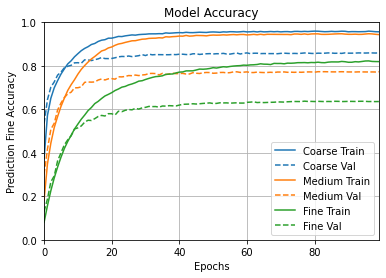

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

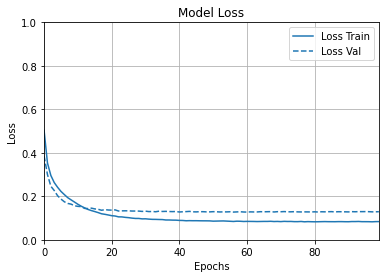

In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 13s 36ms/step - loss: 0.1933 - prediction_coarse_loss: 0.1216 - prediction_medium_loss: 0.1820 - prediction_fine_loss: 0.2805 - prediction_coarse_accuracy: 0.8597 - prediction_medium_accuracy: 0.7731 - prediction_fine_accuracy: 0.6359
1. loss ==> 0.19327256083488464
2. prediction_coarse_loss ==> 0.12162640690803528
3. prediction_medium_loss ==> 0.1820284128189087
4. prediction_fine_loss ==> 0.28052282333374023
5. prediction_coarse_accuracy ==> 0.8597000241279602
6. prediction_medium_accuracy ==> 0.7731000185012817
7. prediction_fine_accuracy ==> 0.6359000205993652
313/313 [==============================] - 10s 29ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

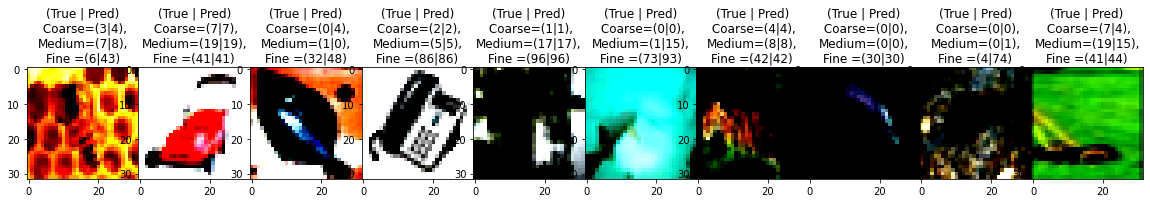

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 720   14   22   31  184    8   11   10]
 [   5 1366   31   28   49   15    2    4]
 [  10   25 1367   14   36   13    8   27]
 [  18   36   29  766  136    1    6    8]
 [  93   22   54   94 2190   11   13   23]
 [  10   30   24    3   34  873    0   26]
 [   6    9   15   15   37    0  417    1]
 [   6    5   30    9   37   14    1  898]]

  • MEDIUM LEVEL 
[[323  26   0   4   0   9   3   7  17   2   4  13  22  13   5  25  22   1
    1   3]
 [ 26 366   7   4   4   5   1   4   2   5   5   4   5  12  12  19  10   1
    4   4]
 [  0   3 446   3  16   2   2  10   0   1   2   0   0   4   2   3   1   3
    2   0]
 [  1   1   6 404  14  34  10   2   2   3   0   1   2   3   4   4   1   0
    3   5]
 [  1   2  26  11 409  10   0   3   4   2   0   2   4  11   2   6   4   1
    1   1]
 [  1   6   0  32   4 385  25   2   0   5   0   2   3   5   6   7   2   1
    4  10]
 [  2   2   0  12   0  28 428   1   0   5   1   0   1   3   4   3   1   1
    6   2]


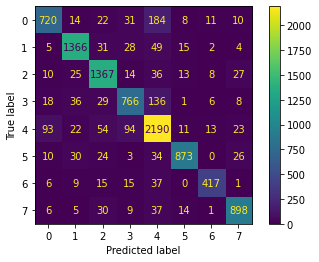

              precision    recall  f1-score   support

           0    0.82949   0.72000   0.77088      1000
           1    0.90644   0.91067   0.90855      1500
           2    0.86959   0.91133   0.88997      1500
           3    0.79792   0.76600   0.78163      1000
           4    0.81021   0.87600   0.84182      2500
           5    0.93369   0.87300   0.90233      1000
           6    0.91048   0.83400   0.87056       500
           7    0.90070   0.89800   0.89935      1000

    accuracy                        0.85970     10000
   macro avg    0.86982   0.84862   0.85814     10000
weighted avg    0.86066   0.85970   0.85918     10000


  • MEDIUM LEVEL 


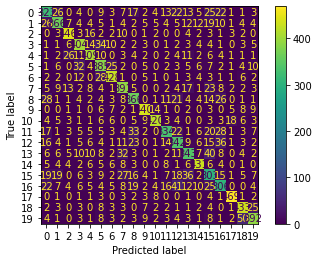

              precision    recall  f1-score   support

           0    0.67012   0.64600   0.65784       500
           1    0.78373   0.73200   0.75698       500
           2    0.85769   0.89200   0.87451       500
           3    0.77842   0.80800   0.79293       500
           4    0.82626   0.81800   0.82211       500
           5    0.70384   0.77000   0.73543       500
           6    0.83757   0.85600   0.84669       500
           7    0.74053   0.78200   0.76070       500
           8    0.72619   0.73200   0.72908       500
           9    0.88176   0.88000   0.88088       500
          10    0.90129   0.84000   0.86957       500
          11    0.78588   0.66800   0.72216       500
          12    0.67589   0.68400   0.67992       500
          13    0.70576   0.68600   0.69574       500
          14    0.85347   0.86200   0.85771       500
          15    0.56636   0.60600   0.58551       500
          16    0.64151   0.61200   0.62641       500
          17    0.92323   0

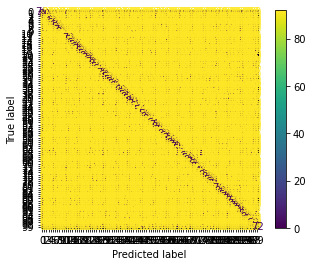

              precision    recall  f1-score   support

           0    0.83516   0.76000   0.79581       100
           1    0.72727   0.80000   0.76190       100
           2    0.50526   0.48000   0.49231       100
           3    0.42391   0.39000   0.40625       100
           4    0.41228   0.47000   0.43925       100
           5    0.61062   0.69000   0.64789       100
           6    0.63551   0.68000   0.65700       100
           7    0.60204   0.59000   0.59596       100
           8    0.82292   0.79000   0.80612       100
           9    0.81000   0.81000   0.81000       100
          10    0.56338   0.40000   0.46784       100
          11    0.46154   0.42000   0.43979       100
          12    0.68571   0.72000   0.70244       100
          13    0.57303   0.51000   0.53968       100
          14    0.50400   0.63000   0.56000       100
          15    0.57843   0.59000   0.58416       100
          16    0.62162   0.69000   0.65403       100
          17    0.86813   0

In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [22]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7531233333333334 
Hierarchical Recall = 0.7731666666666666 
Hierarchical F1-Score = 0.7609186507936507 
Consistency =  0.8864 
Exact Match =  0.61


# Training Again

In [ ]:
model_save_dir = str(directory+'/trained_model_2.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.1088 - prediction_coarse_accuracy: 0.9286 - prediction_medium_accuracy: 0.8979 - prediction_fine_accuracy: 0.7437
  • Coarse Accuracy = 92.86% | Val_Accuracy = 82.08% | LossWeight = 0.32 
  • Medium Accuracy = 89.79% | Val_Accuracy = 71.77% | LossWeight = 0.41 
  • Fine   Accuracy = 74.37% | Val_Accuracy = 58.51% | LossWeight = 0.27 

Epoch 1: val_prediction_fine_accuracy did not improve from 0.63760
781/781 [==============================] - 145s 185ms/step - loss: 0.1088 - prediction_coarse_accuracy: 0.9286 - prediction_medium_accuracy: 0.8979 - prediction_fine_accuracy: 0.7437 - val_loss: 0.1541 - val_prediction_coarse_accuracy: 0.8208 - val_prediction_medium_accuracy: 0.7177 - val_prediction_fine_accuracy: 0.5851 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1085 - prediction_coarse_accuracy: 0.9296 - prediction_medium_accuracy: 0.9007 - prediction_fine_accuracy: 0.7437


Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.0997 - prediction_coarse_accuracy: 0.9414 - prediction_medium_accuracy: 0.9180 - prediction_fine_accuracy: 0.7691
  • Coarse Accuracy = 94.14% | Val_Accuracy = 83.91% | LossWeight = 0.31 
  • Medium Accuracy = 91.80% | Val_Accuracy = 74.83% | LossWeight = 0.40 
  • Fine   Accuracy = 76.91% | Val_Accuracy = 60.53% | LossWeight = 0.29 

Epoch 10: val_prediction_fine_accuracy did not improve from 0.63760
781/781 [==============================] - 145s 185ms/step - loss: 0.0997 - prediction_coarse_accuracy: 0.9414 - prediction_medium_accuracy: 0.9180 - prediction_fine_accuracy: 0.7691 - val_loss: 0.1390 - val_prediction_coarse_accuracy: 0.8391 - val_prediction_medium_accuracy: 0.7483 - val_prediction_fine_accuracy: 0.6053 - lr: 0.0010
Epoch 11/100
781/781 [==============================] - ETA: 0s - loss: 0.0977 - prediction_coarse_accuracy: 0.9424 - prediction_medium_accuracy: 0.9206 - prediction_fine_accuracy: 0.77

781/781 [==============================] - 144s 185ms/step - loss: 0.0894 - prediction_coarse_accuracy: 0.9519 - prediction_medium_accuracy: 0.9352 - prediction_fine_accuracy: 0.8151 - val_loss: 0.1313 - val_prediction_coarse_accuracy: 0.8531 - val_prediction_medium_accuracy: 0.7650 - val_prediction_fine_accuracy: 0.6260 - lr: 6.3025e-04
Epoch 20/100
781/781 [==============================] - ETA: 0s - loss: 0.0882 - prediction_coarse_accuracy: 0.9545 - prediction_medium_accuracy: 0.9381 - prediction_fine_accuracy: 0.8215
  • Coarse Accuracy = 95.45% | Val_Accuracy = 85.58% | LossWeight = 0.32 
  • Medium Accuracy = 93.81% | Val_Accuracy = 76.39% | LossWeight = 0.39 
  • Fine   Accuracy = 82.15% | Val_Accuracy = 63.19% | LossWeight = 0.29 

Epoch 20: val_prediction_fine_accuracy did not improve from 0.63760
781/781 [==============================] - 144s 185ms/step - loss: 0.0882 - prediction_coarse_accuracy: 0.9545 - prediction_medium_accuracy: 0.9381 - prediction_fine_accuracy: 0.821

Epoch 29/100
781/781 [==============================] - ETA: 0s - loss: 0.0857 - prediction_coarse_accuracy: 0.9558 - prediction_medium_accuracy: 0.9436 - prediction_fine_accuracy: 0.8497
  • Coarse Accuracy = 95.58% | Val_Accuracy = 85.38% | LossWeight = 0.34 
  • Medium Accuracy = 94.36% | Val_Accuracy = 76.95% | LossWeight = 0.39 
  • Fine   Accuracy = 84.97% | Val_Accuracy = 63.94% | LossWeight = 0.27 

Epoch 29: val_prediction_fine_accuracy did not improve from 0.64260
781/781 [==============================] - 145s 186ms/step - loss: 0.0857 - prediction_coarse_accuracy: 0.9558 - prediction_medium_accuracy: 0.9436 - prediction_fine_accuracy: 0.8497 - val_loss: 0.1308 - val_prediction_coarse_accuracy: 0.8538 - val_prediction_medium_accuracy: 0.7695 - val_prediction_fine_accuracy: 0.6394 - lr: 3.7735e-04
Epoch 30/100
781/781 [==============================] - ETA: 0s - loss: 0.0838 - prediction_coarse_accuracy: 0.9572 - prediction_medium_accuracy: 0.9456 - prediction_fine_accuracy: 

781/781 [==============================] - 146s 186ms/step - loss: 0.0807 - prediction_coarse_accuracy: 0.9616 - prediction_medium_accuracy: 0.9501 - prediction_fine_accuracy: 0.8725 - val_loss: 0.1295 - val_prediction_coarse_accuracy: 0.8609 - val_prediction_medium_accuracy: 0.7769 - val_prediction_fine_accuracy: 0.6482 - lr: 2.3783e-04
Epoch 39/100
781/781 [==============================] - ETA: 0s - loss: 0.0821 - prediction_coarse_accuracy: 0.9602 - prediction_medium_accuracy: 0.9483 - prediction_fine_accuracy: 0.8710
  • Coarse Accuracy = 96.02% | Val_Accuracy = 86.07% | LossWeight = 0.34 
  • Medium Accuracy = 94.83% | Val_Accuracy = 77.77% | LossWeight = 0.40 
  • Fine   Accuracy = 87.10% | Val_Accuracy = 65.14% | LossWeight = 0.26 

Epoch 39: val_prediction_fine_accuracy improved from 0.64820 to 0.65140, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/W_C_loss\epoch-best.h5
781/781 [==============================] - 146s 187ms/step - loss: 0.0821 - prediction_coarse_accuracy:

Epoch 48/100
562/781 [====================>.........] - ETA: 37s - loss: 0.0804 - prediction_coarse_accuracy: 0.9610 - prediction_medium_accuracy: 0.9503 - prediction_fine_accuracy: 0.8818

In [ ]:
history_dict = history.history

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [ ]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

In [ ]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

In [ ]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [ ]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )